In [27]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 
import skimage.data

In [2]:
ABS_PATH = os.path.abspath("")
IMG_PATH = os.path.join(ABS_PATH, "images", "images")

In [3]:
imgs = [plt.imread(os.path.join(IMG_PATH, img)) for img in os.listdir(IMG_PATH)]

In [269]:
def get_gaussian_noise(x, mu=0, std=10):
    return (1/std*np.pi**0.5) * np.exp(-1/2*((x-mu)/std)**2)


frame = skimage.data.coins().astype(np.float64)
frame = frame.reshape(frame.shape[0], frame.shape[1], 1)
white_noise = np.random.randint(0, 255, frame.shape)
pepper_salt = np.where(white_noise>250, 255, 0) + np.where(white_noise<5, -255, 0)

gaussian_noise = get_gaussian_noise(white_noise)
# gaussian_noise = get_gaussian_noise(np.where(white_noise>180, white_noise, 0))
# gaussian_noise -= get_gaussian_noise(np.where(white_noise<50, white_noise, 0))
gaussian_noise *= 255/gaussian_noise.max()
# gaussian_noise *= (white_noise/255 -0.5)

frames = [frame, np.clip(frame+pepper_salt, 0 ,255), np.clip(frame+gaussian_noise, 0, 255)]


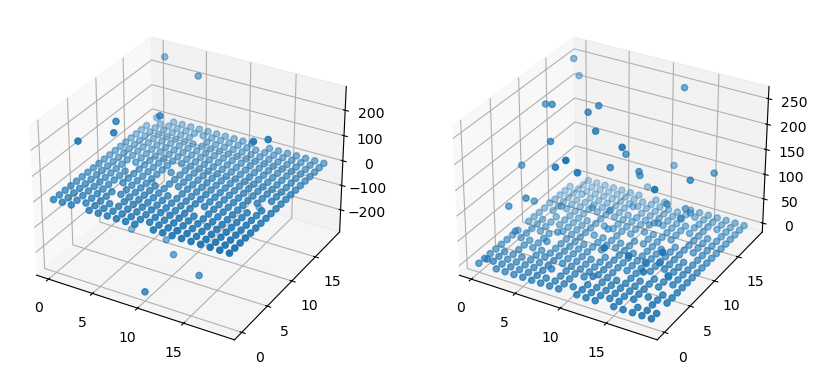

In [270]:
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(10,5))

x, y = np.meshgrid(np.arange(frame.shape[0])[:20], np.arange(frame.shape[1])[:20])
x, y = x.ravel(), y.ravel()
z1 = pepper_salt.ravel()[:400]
z2 = gaussian_noise.ravel()[:400]

ax1.scatter(x, y, z1);
ax2.scatter(x, y, z2);

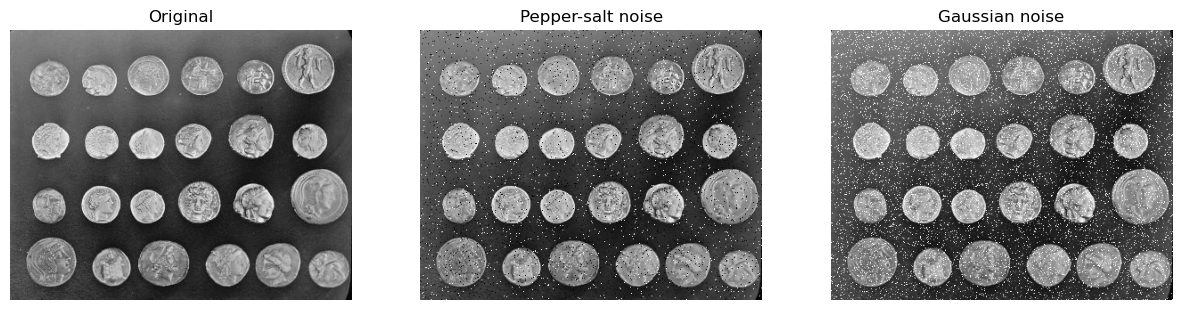

In [271]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
titles = ["Original", "Pepper-salt noise", "Gaussian noise"]

for ax, x, t in zip(axes, frames, titles):
    ax.imshow(x, cmap="gray");
    ax.set_title(f"{t}")
    ax.axis("off")


In [212]:
def local_operator(frame, kernel_size, function):
    
    k, n = kernel_size[0]//2, kernel_size[1]//2
    res_frame = np.zeros_like(frame[k:, n:])
    
    for c in range(frame.shape[2]):
        for i in range(k, frame.shape[0]-k):
            for j in range(n, frame.shape[1]-n):
                curr_frame = frame[i-k:i+1+k,j-n:j+n+1, c]
                res_frame[i-k,j-n, c] = function(curr_frame)
    return res_frame


def get_knn(frame, k=4):
    return np.sort(frame)[:k].mean() 

def get_snn(frame, k=5):
    return frame[0,0]

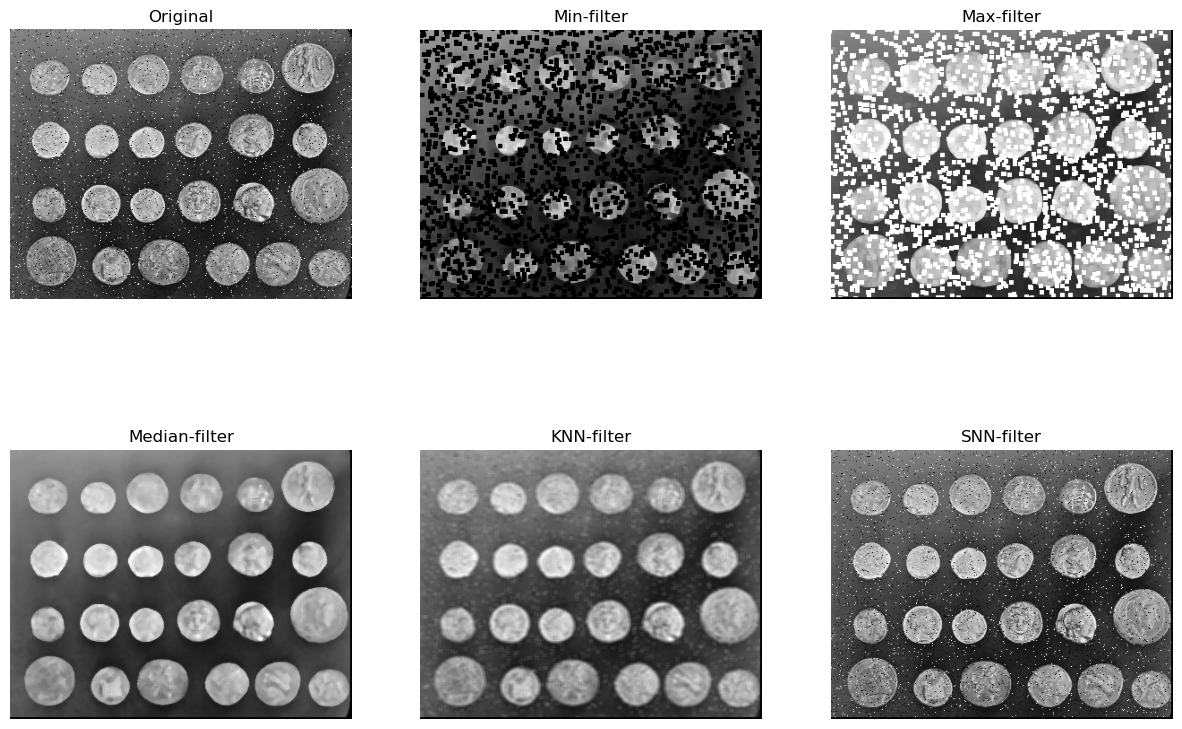

In [273]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
titles = ["Original", "Min-filter", "Max-filter", "Median-filter", "KNN-filter", "SNN-filter"]

i = 1
kernel_size = (5,5)
min_frame = local_operator(frames[i], kernel_size, lambda x: x.min())
max_frame = local_operator(frames[i], kernel_size, lambda x: x.max())
median_frame = local_operator(frames[i], kernel_size, lambda x: np.median(x))
knn_frame = local_operator(frames[i], kernel_size, get_knn)
snn_frame = local_operator(frames[i], kernel_size, get_snn)


lo_frames = [frames[i], min_frame, max_frame, median_frame, knn_frame, snn_frame]

for ax, x, t in zip([y for ax in axes for y in ax], lo_frames, titles):
    ax.imshow(x, cmap="gray");
    ax.set_title(f"{t}")
    ax.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


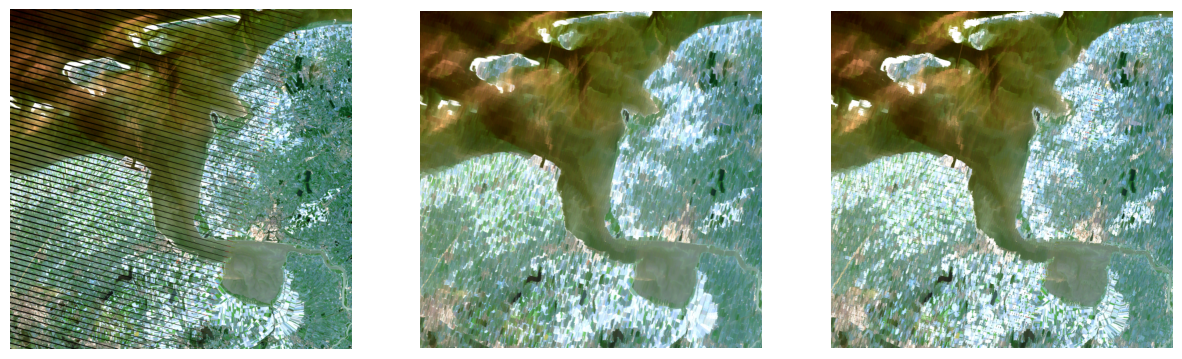

In [118]:
from scipy import ndimage

img = imgs[0]

img1 = local_operator(ndimage.rotate(img, 15), (7,1), lambda x: x.max())
img2 = local_operator(img1, (7,1), lambda x: x.min())
img3 = ndimage.rotate(img2, -15, reshape=False)[75:-75, 75:-75]



def local_operator2(frame, kernel_size, function):
    
    k, n = kernel_size[0]//2, kernel_size[1]//2
    res_frame = np.zeros_like(frame[k:, n:])
    coors = []

    for c in range(3):
        for i in range(k, frame.shape[0]-k):
            for j in range(n, frame.shape[1]-n):

                curr_frame = frame[i-k:i+1+k,j-n:j+n+1, c]
                if curr_frame.min() < 0.5:
                    res_frame[i-k,j-n, c] = function(curr_frame)
                else: coors.append([i,j])

    for coors in coors: 
        i,j = coors
        res_frame[i-k,j-n] = frame[i,j]
    return res_frame


img4 = local_operator2(ndimage.rotate(img, 15), (7,1), lambda x: x.max())
img5 = local_operator2(img4, (7,1), lambda x: x.min())
img6 = ndimage.rotate(img5, -15, reshape=False)[75:-75, 75:-75]


fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))

ax1.imshow(img)
ax2.imshow(img3)
ax3.imshow(img6)
ax1.axis("off");
ax2.axis("off");
ax3.axis("off");